In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify as mc
import plotly.express as px
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('fbprophet.diagnostics').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.cluster import KMeans

In [2]:
stations_df = pd.read_excel('data/2018-APTA-Infrastructure-Database.xlsx', sheet_name="Station Data")
raw_df = pd.read_excel('data/February 2022 Raw Database.xlsx', sheet_name = 'MASTER')
rail_df = pd.read_excel('data/2018-APTA-Infrastructure-Database.xlsx', sheet_name="Rail Lines")
bus_df = pd.read_excel('data/2018-APTA-Infrastructure-Database.xlsx', sheet_name="BRT lines")
trips_df = pd.read_excel('data/February 2022 Raw database.xlsx', sheet_name="UPT")
trips_df = trips_df[trips_df['Active'] == 'Active'].groupby(['5 digit NTD ID', 'Agency']).sum().reset_index()

In [3]:
station_cols = ["Organization Name", "Organization Short Name",	"City",	"State",	"Country",
                "Member ID",	"Type of Facility",	"Number of Stations", "Number of Bus/Rail Stops"]
station_df_short = stations_df[station_cols]
station_df_short

,Organization Name,Organization Short Name,City,State,Country,Member ID,Type of Facility,Number of Stations,Number of Bus/Rail Stops
0,City of Phoenix Public Transit Department,City of Phoenix PTD,Phoenix,AZ,UNITED STATES,6,BUS,15,3994
1,City of Phoenix Public Transit Department,City of Phoenix PTD,Phoenix,AZ,UNITED STATES,6,RAIL,35,0
2,City of Tucson Mass Transit System,City of Tucson MTS,Tucson,AZ,UNITED STATES,7,BUS,23,2291
3,Rock Region METRO,Central Arkansas TA,Little Rock,AR,UNITED STATES,8,BUS,1,1548
4,Rock Region METRO,Central Arkansas TA,Little Rock,AR,UNITED STATES,8,RAIL,0,15
...,...,...,...,...,...,...,...,...,...
496,Bow Valley Regional Transit Services Commission,Roam Transit,Banff,AB,CANADA,98842,BUS,1,80
497,Link Transit (City of Burlington NC),Link Transit,Burlington,NC,UNITED STATES,105173,BUS,1,150
498,University of California San Francisco,NaN,San Francisco,CA,UNITED STATES,119308,BUS,0,0
499,Strathcona County Transit,Strathcona County Transit,Sherwood Park,AB,CANADA,131921,BUS,2,320


In [4]:
rawDB_cols = ["5 digit NTD ID", "Agency", "Mode", "HQ City", "HQ State", "UZA", "UZA Name", 
              "UZA Area SQ Miles", "UZA Population", "Service Area SQ Miles", 
              "Service Area Population", "Passenger Miles FY", "Unlinked Passenger Trips FY", 
              "Average Trip Length FY"]
rawDB_df_short = raw_df[rawDB_cols]
rawDB_df_short

,5 digit NTD ID,Agency,Mode,HQ City,HQ State,UZA,UZA Name,UZA Area SQ Miles,UZA Population,Service Area SQ Miles,Service Area Population,Passenger Miles FY,Unlinked Passenger Trips FY,Average Trip Length FY
0,1,King County Department of Metro Transit,DR,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,4551838.0,455391.0,9.9955
1,1,King County Department of Metro Transit,DR,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,1003831.0,86460.0,11.6104
2,1,King County Department of Metro Transit,FB,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,896100.0,146930.0,6.0988
3,1,King County Department of Metro Transit,LR,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,NaN,NaN,NaN
4,1,King County Department of Metro Transit,MB,SEATTLE,WA,14,"Seattle, WA",1010.0,3059393.0,2134.0,2260800.0,210354213.0,48865809.0,4.3047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,99423,City of Glendale,MB,GLENDALE,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,39.0,223467.0,2278590.0,1040034.0,2.1909
2246,99424,City of Pasadena,DR,Pasadena,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,23.0,141371.0,235921.0,68517.0,3.4432
2247,99424,City of Pasadena,MB,Pasadena,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,23.0,141371.0,2439762.0,1305756.0,1.8685
2248,99425,Pomona Valley Transportation Authority,DR,LA VERNE,CA,2,"Los Angeles-Long Beach-Anaheim, CA",1736.0,12150996.0,61.0,252880.0,279733.0,62210.0,4.4966


In [5]:
match = 0
for i in sorted(set(rawDB_df_short['Agency'])):
  if i in sorted(set(station_df_short['Organization Name'])):
    print(i)
    match += 1
print(match)

Alameda-Contra Costa Transit District
Altoona Metro Transit
Ames Transit Agency
Antelope Valley Transit Authority
Arlington County, Virginia
Beaver County Transit Authority
Ben Franklin Transit
Birmingham-Jefferson County Transit Authority
Bloomington Public Transportation Corporation
Brazos Transit District
Brunswick Transit Alternative
Butler County Regional Transit Authority
Cambria County Transit Authority
Cape Fear Public Transportation Authority
Capital Area Transit System
Capital Area Transportation Authority
Capital District Transportation Authority
Capital Metropolitan Transportation Authority
Casco Bay Island Transit District
Central Florida Regional Transportation Authority
Central New York Regional Transportation Authority
Central Ohio Transit Authority
Central Oklahoma Transportation and Parking Authority
Central Puget Sound Regional Transit Authority
Centre Area Transportation Authority
Champaign-Urbana Mass Transit District
Charleston Area Regional Transportation Authori

In [6]:


#summing trips/miles, storing Area and pop for each agency
agency = list(set(rawDB_df_short['Agency']))
area = []
pop= []
pass_miles = []
pass_trips = []
trip_length = []
type_count = []
ntd_id=[]

for i in agency:
  tmpDF = rawDB_df_short[rawDB_df_short['Agency'] == i]
  area.append(list(tmpDF['Service Area SQ Miles'])[0])
  pop.append(list(tmpDF['Service Area Population'])[0])
  pass_miles.append(sum(pd.to_numeric(tmpDF['Passenger Miles FY']).dropna()))
  pass_trips.append(sum(pd.to_numeric(tmpDF['Unlinked Passenger Trips FY']).dropna()))
  type_count.append(len(set(tmpDF['Mode'])))
  ntd_id.append(list(tmpDF['5 digit NTD ID'])[0])
  if pass_trips[-1] != 0:
    trip_length.append(pass_miles[-1]/pass_trips[-1])
  else: trip_length.append(0)

rawDB_df_combined = pd.DataFrame({"NTDID":ntd_id, "Agency": agency, "Service Area": area, 
                                  "Service Pop.": pop, "Passenger Miles": pass_miles, 
                                  "Passenger Trips": pass_trips, "Avg. Trip Length": trip_length,
                                  "Transportation Modes": type_count})

# combining Station data by organization
organization = list(set(station_df_short['Organization Name']))
org_short = []
city = []
state = []
country = []
memberID = [] 
stations = [] 
stops = [] 

for i in organization:
  tmpDF = station_df_short[station_df_short['Organization Name'] == i]
  org_short.append(list(tmpDF['Organization Short Name'])[0])
  city.append(list(tmpDF['City'])[0])
  state.append(list(tmpDF['State'])[0])
  country.append(list(tmpDF['Country'])[0])
  memberID.append(list(tmpDF['Member ID'])[0])
  stations.append(sum(pd.to_numeric(tmpDF['Number of Stations']).dropna()))
  stops.append(sum(pd.to_numeric(tmpDF['Number of Bus/Rail Stops']).dropna()))

station_df_combined = pd.DataFrame({"Organization Name": organization, "Organization Short Name": org_short,
                                    "City": city, "State": state, "Country": country,
                                    "Member ID": memberID, "Number of Stations": stations,
                                    "Number of Bus/Rail Stops": stops})

In [7]:
station_org = list(station_df_combined["Organization Name"])
rawDB_agency = list(rawDB_df_combined["Agency"])

matched = {} #{Organzation: Agency}

for i in station_org:
  start = 0
  end = 4
  matches = [agency for agency in rawDB_agency if i[start:end] in agency]
  while (len(matches) > 1) and (end < len(i)):
    end +=1
    matches = [agency for agency in matches if i[start:end] in agency]
  matched[i] = [len(matches), matches]

In [8]:
station_df_combined['Agency'] = station_df_combined['Organization Name']
#combined_df = station_df_short.merge(rawDB_df_combined, how = "inner", on="Agency")
total = 0
for i in matched:
  if matched[i][0] == 1:
    total += 1
    org_index = station_df_combined[station_df_combined['Organization Name']== i].index[0]
    #print(i, ':',org_index)
    agency_index = rawDB_df_combined[rawDB_df_combined['Agency'] == matched[i][1][0]].index[0]
    #print(matched[i][1][0],':', agency_index, "\n")
    station_df_combined.loc[org_index,['Agency']] = rawDB_df_combined.iloc[agency_index]['Agency']

print("total", total)

total 302


In [9]:
combined_df = station_df_combined.merge(rawDB_df_combined, how = "inner", on="Agency")

In [10]:
for i in set(list(combined_df['Agency'])):
  tmpDF = combined_df[combined_df['Agency']==i]
  if len(tmpDF) > 1:
    if len(tmpDF) == 2:
      print(tmpDF.index[0],':', list(tmpDF['Organization Name'])[0],';', list(tmpDF['Agency'])[0])
      print(tmpDF.index[1],':', list(tmpDF['Organization Name'])[1],';', list(tmpDF['Agency'])[1], "\n")
    if len(tmpDF) == 3:
      print(tmpDF.index[0],':', list(tmpDF['Organization Name'])[0],';', list(tmpDF['Agency'])[0])
      print(tmpDF.index[1],':', list(tmpDF['Organization Name'])[1],';', list(tmpDF['Agency'])[1])
      print(tmpDF.index[2],':', list(tmpDF['Organization Name'])[2],';', list(tmpDF['Agency'])[2], "\n")

23 : Mountain Line Transit Authority ; Green Mountain Transit Authority
24 : Mountain Area Regional Transit Authority ; Green Mountain Transit Authority
25 : Mountain Metropolitan Transit ; Green Mountain Transit Authority 

2 : Madison County Transit District ; Madison County Transit District
3 : Madison Metro ; Madison County Transit District 

106 : Pierce Transit ; Pierce County Transportation Benefit Area Authority
107 : Pierce County Ferry Operations ; Pierce County Transportation Benefit Area Authority 

52 : Southern Nevada Transit Coalition ; Regional Transportation Commission of Southern Nevada
53 : Regional Transportation Commission of Southern Nevada ; Regional Transportation Commission of Southern Nevada 

145 : Butler Township/City Joint Municipal Transit Authority ; Butler County Regional Transit Authority
146 : Butler County Regional Transit Authority ; Butler County Regional Transit Authority 

117 : Southwest Ohio Regional Transit Authority ; Southwest Ohio Regional T

In [11]:
# combining Station data by organization
organization_rail = list(set(rail_df['Organization Name']))
memberID = [] 
miles = [] 
max_speed = []

for i in organization_rail:
  tmpDF = rail_df[rail_df['Organization Name'] == i]
  memberID.append(list(tmpDF['Member ID'])[0])
  rail_miles = sum(pd.to_numeric(tmpDF['Miles of mainline passenger track']).dropna())
  if i in list(set(bus_df['Organization Name'])):
    tmpDF2 = bus_df[bus_df['Organization Name'] == i]
    bus_miles = sum(pd.to_numeric(tmpDF2['Route Length (Miles)']).dropna())
    miles.append(bus_miles+rail_miles)
  else: 
    miles.append(rail_miles)
  max_speed.append(sum(pd.to_numeric(tmpDF['Maximum speed (m.p.h.)']).dropna()))

rail_bus_df_combined = pd.DataFrame({"Organization Name": organization_rail, "Member ID": memberID,
                                     "Miles": miles, "Max. Speed": max_speed})


combined_df_with_miles = combined_df.merge(rail_bus_df_combined, how = "left", on="Member ID")

In [12]:
# combine the dataframes

trips_combined_df = combined_df.merge(trips_df, left_on=['NTDID','Agency'], right_on=['5 digit NTD ID', 'Agency'], how='inner')
trips_combined_df['Stops'] = trips_combined_df['Number of Stations'] + trips_combined_df['Number of Bus/Rail Stops']
trips_combined_df.head(2)

,Organization Name,Organization Short Name,City,State,Country,Member ID,Number of Stations,Number of Bus/Rail Stops,Agency,NTDID,...,JUN21,JUL21,AUG21,SEP21,OCT21,NOV21,DEC21,JAN22,FEB22,Stops
0,Port Arthur Transit,Port Arthur Transit,Port Arthur,TX,UNITED STATES,242,1,479,City of Port Arthur,60013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480
1,Fargo Metropolitan Area Transit System,Fargo Metropolitan Area Transit System,Fargo,ND,UNITED STATES,1017,1,750,City of Fargo,80003,...,51742.0,55378.0,64779.0,89545.0,88439.0,80128.0,66203.0,66805.0,74484.0,751


In [13]:
trips_filtered_df = trips_combined_df.groupby(['City','State']).sum().reset_index()
pre_pandamic_columns = ['JAN02','FEB02','MAR02','APR02','MAY02','JUN02','JUL02','AUG02','SEP02','OCT02','NOV02','DEC02',
                        'JAN03','FEB03','MAR03','APR03','MAY03','JUN03','JUL03','AUG03','SEP03','OCT03','NOV03','DEC03',
                        'JAN04','FEB04','MAR04','APR04','MAY04','JUN04','JUL04','AUG04','SEP04','OCT04','NOV04','DEC04',
                        'JAN05','FEB05','MAR05','APR05','MAY05','JUN05','JUL05','AUG05','SEP05','OCT05','NOV05','DEC05',
                        'JAN06','FEB06','MAR06','APR06','MAY06','JUN06','JUL06','AUG06','SEP06','OCT06','NOV06','DEC06',
                        'JAN07','FEB07','MAR07','APR07','MAY07','JUN07','JUL07','AUG07','SEP07','OCT07','NOV07','DEC07',
                        'JAN08','FEB08','MAR08','APR08','MAY08','JUN08','JUL08','AUG08','SEP08','OCT08','NOV08','DEC08',
                        'JAN09','FEB09','MAR09','APR09','MAY09','JUN09','JUL09','AUG09','SEP09','OCT09','NOV09','DEC09',
                        'JAN10','FEB10','MAR10','APR10','MAY10','JUN10','JUL10','AUG10','SEP10','OCT10','NOV10','DEC10',
                        'JAN11','FEB11','MAR11','APR11','MAY11','JUN11','JUL11','AUG11','SEP11','OCT11','NOV11','DEC11',
                        'JAN12','FEB12','MAR12','APR12','MAY12','JUN12','JUL12','AUG12','SEP12','OCT12','NOV12','DEC12',
                        'JAN13','FEB13','MAR13','APR13','MAY13','JUN13','JUL13','AUG13','SEP13','OCT13','NOV13','DEC13',
                        'JAN14','FEB14','MAR14','APR14','MAY14','JUN14','JUL14','AUG14','SEP14','OCT14','NOV14','DEC14',
                        'JAN15','FEB15','MAR15','APR15','MAY15','JUN15','JUL15','AUG15','SEP15','OCT15','NOV15','DEC15',
                        'JAN16','FEB16','MAR16','APR16','MAY16','JUN16','JUL16','AUG16','SEP16','OCT16','NOV16','DEC16',
                        'JAN17','FEB17','MAR17','APR17','MAY17','JUN17','JUL17','AUG17','SEP17','OCT17','NOV17','DEC17',
                        'JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18','DEC18',
                        'JAN19','FEB19','MAR19','APR19','MAY19','JUN19','JUL19','AUG19','SEP19','OCT19','NOV19','DEC19',
                        'City','State']
post_pandamic_columns = ['JAN02','FEB02','MAR02','APR02','MAY02','JUN02','JUL02','AUG02','SEP02','OCT02','NOV02','DEC02',
                        'JAN03','FEB03','MAR03','APR03','MAY03','JUN03','JUL03','AUG03','SEP03','OCT03','NOV03','DEC03',
                        'JAN04','FEB04','MAR04','APR04','MAY04','JUN04','JUL04','AUG04','SEP04','OCT04','NOV04','DEC04',
                        'JAN05','FEB05','MAR05','APR05','MAY05','JUN05','JUL05','AUG05','SEP05','OCT05','NOV05','DEC05',
                        'JAN06','FEB06','MAR06','APR06','MAY06','JUN06','JUL06','AUG06','SEP06','OCT06','NOV06','DEC06',
                        'JAN07','FEB07','MAR07','APR07','MAY07','JUN07','JUL07','AUG07','SEP07','OCT07','NOV07','DEC07',
                        'JAN08','FEB08','MAR08','APR08','MAY08','JUN08','JUL08','AUG08','SEP08','OCT08','NOV08','DEC08',
                        'JAN09','FEB09','MAR09','APR09','MAY09','JUN09','JUL09','AUG09','SEP09','OCT09','NOV09','DEC09',
                        'JAN10','FEB10','MAR10','APR10','MAY10','JUN10','JUL10','AUG10','SEP10','OCT10','NOV10','DEC10',
                        'JAN11','FEB11','MAR11','APR11','MAY11','JUN11','JUL11','AUG11','SEP11','OCT11','NOV11','DEC11',
                        'JAN12','FEB12','MAR12','APR12','MAY12','JUN12','JUL12','AUG12','SEP12','OCT12','NOV12','DEC12',
                        'JAN13','FEB13','MAR13','APR13','MAY13','JUN13','JUL13','AUG13','SEP13','OCT13','NOV13','DEC13',
                        'JAN14','FEB14','MAR14','APR14','MAY14','JUN14','JUL14','AUG14','SEP14','OCT14','NOV14','DEC14',
                        'JAN15','FEB15','MAR15','APR15','MAY15','JUN15','JUL15','AUG15','SEP15','OCT15','NOV15','DEC15',
                        'JAN16','FEB16','MAR16','APR16','MAY16','JUN16','JUL16','AUG16','SEP16','OCT16','NOV16','DEC16',
                        'JAN17','FEB17','MAR17','APR17','MAY17','JUN17','JUL17','AUG17','SEP17','OCT17','NOV17','DEC17',
                        'JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18','DEC18',
                        'JAN19','FEB19','MAR19','APR19','MAY19','JUN19','JUL19','AUG19','SEP19','OCT19','NOV19','DEC19',
                        'JAN20','FEB20','MAR20','APR20','MAY20','JUN20','JUL20','AUG20','SEP20','OCT20','NOV20','DEC20',
                        'JAN21','FEB21','MAR21','APR21','MAY21','JUN21','JUL21','AUG21','SEP21','OCT21','NOV21','DEC21',
                        'JAN22','FEB22',
                        'City','State']
trips_filtered_df = trips_filtered_df[pre_pandamic_columns]
trips_filtered_df = pd.melt(trips_filtered_df, id_vars=['City','State'], value_vars=pre_pandamic_columns)
trips_filtered_df.columns = ['City','State','Date','Trips']
trips_filtered_df.head(2)

,City,State,Date,Trips
0,Akron,OH,JAN02,0.0
1,Albany,NY,JAN02,992692.0


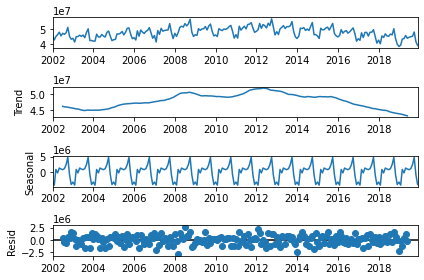

<Figure size 1080x1080 with 0 Axes>

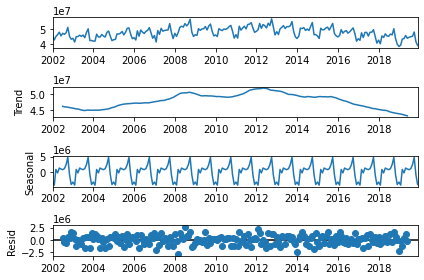

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
trips_compare_df = trips_filtered_df.query('(City == "Chicago" & State == "IL")')
trips_compare_df.Date = pd.to_datetime(trips_compare_df.Date, format='%b%y')
trips_compare_df.set_index('Date', inplace=True)

analysis = trips_compare_df[['Trips']].copy()
plt.figure(figsize=(15,15))

decompose_result_mult = seasonal_decompose(analysis, period=12)
decompose_result_mult.plot()

In [15]:
def evaluate_prophet_model(X):
	split_point = len(X) - 5
	test = X.loc[split_point:]

	model = Prophet(interval_width=0.90)
	model_fit = model.fit(X)

	dates = test["ds"].to_list()
 
	cutoffs = pd.date_range(start='2019-01-01', end='2019-12-01', freq='1M')

	#hor = np.abs(np.max(dates[:-1]) - np.min(dates)) - 1

	df_cv = cross_validation(model_fit, horizon='60 days', cutoffs=cutoffs, parallel="processes")

	df_p = performance_metrics(df_cv)
	# make predictions
	rmse = np.mean(df_p["rmse"].to_list())
	print(f'RMSE:{rmse}')
	return df_p

In [16]:
trips_compare_df.reset_index(inplace=True)
df2 = trips_compare_df[['Date','Trips']].copy()
df2.rename(columns={'Date':'ds', 'Trips':'y'}, inplace=True)
#evaluate_prophet_model(df2)

split_point = len(df2) - 5
test = df2.loc[split_point:]

model = Prophet(interval_width=0.90)
model_fit = model.fit(df2)

dates = test["ds"].to_list()

cutoffs = pd.date_range(start='2019-01-01', end='2019-11-01', freq='1M')

#hor = np.abs(np.max(dates[:-1]) - np.min(dates)) - 1

df_cv = cross_validation(model_fit, horizon='30 days', cutoffs=cutoffs, parallel="processes")

df_p = performance_metrics(df_cv)
# make predictions
rmse = np.mean(df_p["rmse"].to_list())
print(f'RMSE:{rmse}')
df_p

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D40870A2B0>


RMSE:897311.5988403817


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,3.831277e+11,6.189731e+05,5.298398e+05,0.012063,0.012138,0.012065,1.0
1,29 days,1.382153e+12,1.175650e+06,1.175650e+06,0.027187,0.027187,0.026822,1.0


In [17]:
future = model_fit.make_future_dataframe(periods=820)
forecast = model_fit.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1031,2022-02-24,3.662864e+07,3.470446e+07,3.850603e+07
1032,2022-02-25,3.742571e+07,3.551089e+07,3.944512e+07
1033,2022-02-26,3.821212e+07,3.605654e+07,4.015363e+07
1034,2022-02-27,3.897252e+07,3.705786e+07,4.087316e+07
1035,2022-02-28,3.969219e+07,3.775244e+07,4.173705e+07


In [18]:
trips_filtered_df = trips_combined_df.groupby(['City','State']).sum().reset_index()
trips_filtered_df = trips_filtered_df[post_pandamic_columns]
trips_filtered_df = pd.melt(trips_filtered_df, id_vars=['City','State'], value_vars=post_pandamic_columns)
trips_filtered_df.columns = ['City','State','Date','Trips']
trips_compare_df = trips_filtered_df.query('(City == "Chicago" & State == "IL")')
trips_compare_df.Date = pd.to_datetime(trips_compare_df.Date, format='%b%y')
trips_compare_df.set_index('Date', inplace=True)

In [19]:
results_df = trips_compare_df.merge(forecast, left_on="Date", right_on="ds", how="inner")
results_df.rename(columns={"yhat":"y1hat"}, inplace=True)

In [20]:
trips_compare_df.reset_index(inplace=True)
df2 = trips_compare_df[['Date','Trips']].copy()
df2.rename(columns={'Date':'ds', 'Trips':'y'}, inplace=True)
#evaluate_prophet_model(df2)

split_point = len(df2) - 5
test = df2.loc[split_point:]

model = Prophet(interval_width=0.90)
model_fit = model.fit(df2)

dates = test["ds"].to_list()

cutoffs = pd.date_range(start='2019-01-01', end='2019-11-01', freq='1M')

#hor = np.abs(np.max(dates[:-1]) - np.min(dates)) - 1

df_cv = cross_validation(model_fit, horizon='30 days', cutoffs=cutoffs, parallel="processes")

df_p = performance_metrics(df_cv)
# make predictions
rmse = np.mean(df_p["rmse"].to_list())
print(f'RMSE:{rmse}')
df_p

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D40870AB20>


RMSE:897311.5988403817


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,3.831277e+11,6.189731e+05,5.298398e+05,0.012063,0.012138,0.012065,1.0
1,29 days,1.382153e+12,1.175650e+06,1.175650e+06,0.027187,0.027187,0.026822,1.0


In [21]:
future = model_fit.make_future_dataframe(periods=10)
forecast = model_fit.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
247,2022-02-07,8.627876e+06,1.197445e+06,1.554492e+07
248,2022-02-08,7.421130e+06,-2.269155e+05,1.456370e+07
249,2022-02-09,6.131769e+06,-1.631108e+06,1.284093e+07
250,2022-02-10,4.798040e+06,-2.120642e+06,1.221991e+07
251,2022-02-11,3.461016e+06,-3.849351e+06,9.907667e+06


In [22]:
results_df = results_df.merge(forecast, left_on="ds", right_on="ds", how="inner")
results_df.rename(columns={"yhat":"y2hat"}, inplace=True)

In [23]:
import plotly.graph_objects as go

x = results_df['ds']
y = results_df['Trips']
y1=results_df['y1hat']
y2=results_df['y2hat']

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines',
                    name='Prepandamic'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines', name='Pandamic'))

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(title_text='Chicago Transportation predictions', xaxis_title='Date', yaxis_title='Trips', title_x=0.5, title_font={'size':20})

fig.show()

In [24]:
trips_compare_df = trips_filtered_df.query('(City == "Los Angeles" & State == "CA") | \
                                       (City == "Chicago" & State == "IL") | \
                                       (City == "Boston" & State == "MA")')
fig1 = px.area(trips_compare_df, x='Date', y='Trips', color='City')
fig1.update_layout(title='Passenger Trips', xaxis_title='Date', yaxis_title='Trips', title_x=0.5, title_font={'size':20})
fig1.update_xaxes(rangeslider_visible=True)
fig1.show()

In [25]:
trips_compare_df = trips_filtered_df.query('(City == "Arlington") | \
                                       (City == "Lindenwold")')
fig1 = px.area(trips_compare_df, x='Date', y='Trips', color='City')
fig1.update_layout(title='Passenger Trips', xaxis_title='Date', yaxis_title='Trips', title_x=0.5, title_font={'size':20})
fig1.update_xaxes(rangeslider_visible=True)
fig1.show()

In [26]:
# Estract the stations and stops for NON-FERRY data from the raw data
# Calculate the total number of stops per City

stations_sub_df = stations_df[stations_df['Type of Facility'] != 'FERRY'].groupby(['City','State'])[['Number of Stations', 'Number of Bus/Rail Stops']].sum().reset_index()
stations_sub_df['Stops'] = stations_sub_df['Number of Bus/Rail Stops'] + stations_sub_df['Number of Stations']
stations_sub_df = stations_sub_df.loc[:, ['City','State','Stops']]
stations_sub_df.head(2)

,City,State,Stops
0,Abilene,TX,501
1,Akron,OH,3648


In [27]:
# filter Active Agencies and extract HQ City, HQ State and Service Area SQ Miles columns

raw_sub_df = raw_df[raw_df["Active"] == "Active"].loc[:,raw_df.columns.isin(['HQ City','HQ State','Service Area SQ Miles', 'Service Area Population'])].drop_duplicates()
raw_sub_df.head(2)

,HQ City,HQ State,Service Area SQ Miles,Service Area Population
0,SEATTLE,WA,2134.0,2260800.0
9,SPOKANE,WA,248.0,442499.0


In [28]:
#raw_sub_df[raw_sub_df['HQ City'].str.lower() == 'alexandria']
#convert all cities and states to lower case
raw_sub_df['HQ City lower'] = raw_sub_df['HQ City'].str.lower()
raw_sub_df['HQ State lower'] = raw_sub_df['HQ State'].str.lower()

stations_sub_df['City lower'] = stations_sub_df['City'].str.lower()
stations_sub_df['State lower'] = stations_sub_df['State'].str.lower()

In [29]:
# Merge raw and station data

merged_df = stations_sub_df.merge(raw_sub_df, left_on=['City lower','State lower'], 
                                  right_on=['HQ City lower','HQ State lower'], 
                                  how='inner', sort=True)[['City','State','City lower','State lower','Stops','Service Area SQ Miles','Service Area Population']]

In [30]:
merged_df = merged_df.groupby(['City','State','Stops', 'City lower', 'State lower']).agg({'Service Area SQ Miles':'sum','Service Area Population':'max'}).reset_index()
merged_df.replace(0,np.nan, inplace=True)
merged_df.dropna(inplace=True)

In [31]:
merged_df['StopsPerMile'] = merged_df['Stops'] / merged_df['Service Area SQ Miles']
#merged_df['MilesPerStop'] = merged_df['Service Area SQ Miles'] / merged_df['Stops']
merged_df['StopsPerPop'] = merged_df['Stops'] / merged_df['Service Area Population']
merged_df['PopDensity'] = merged_df['Service Area Population'] / merged_df['Service Area SQ Miles']
#merged_df['PopulationPerStop'] = merged_df['Service Area SQ Miles'] / merged_df['Stops']

In [32]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(merged_df.loc[:,merged_df.columns.isin(['StopsPerMile', 'PopDensity'])])
    distortions.append(kmeanModel.inertia_)

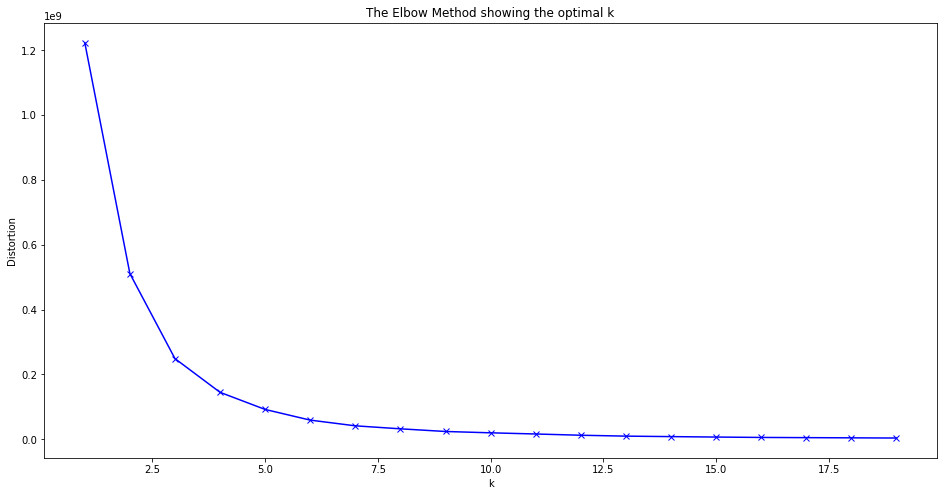

In [33]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(merged_df.loc[:,merged_df.columns.isin(['StopsPerMile', 'PopDensity'])])
merged_df['k_means']=kmeanModel.predict(merged_df.loc[:,merged_df.columns.isin(['StopsPerMile', 'PopDensity'])])
merged_df['k_means']=merged_df['k_means'].astype("category")

In [35]:
print(type(merged_df[merged_df['City']=='Lindenwold']['PopDensity'].values[0]))

<class 'numpy.float64'>


In [36]:
fig1 = px.scatter(merged_df, y='Stops', x='PopDensity', hover_data=['City','State'], 
                  log_y=True, labels = {'k_means': "Groups", 'PopDensity':'Population Density'},
                  color="k_means",  category_orders={"k_means": [0,3,2,1]},)
fig1.update_layout(title_text='Stops Vs Service Area Population', title_x=0.5, title_font=dict(size=20))
#fig1.update_traces(textposition='top right')
newnames = {'0':'Less Population', '3': 'Normal Population','2':'Above Normal Population', '1': 'Dense Population'}
fig1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig1.update_layout(legend={'title_text':''})
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Lindenwold']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Lindenwold']['PopDensity'].values[0],
            text="Lindenwold",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Chicago']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Chicago']['PopDensity'].values[0],
            text="Chicago",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='New York']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='New York']['PopDensity'].values[0],
            text="New York",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Boston']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Boston']['PopDensity'].values[0],
            text="Boston",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='San Jose']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='San Jose']['PopDensity'].values[0],
            text="San Jose",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Norwalk']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Norwalk']['PopDensity'].values[0],
            text="Norwalk",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Santa Monica']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Santa Monica']['PopDensity'].values[0],
            text="Santa Monica",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Pompano Beach']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Pompano Beach']['PopDensity'].values[0],
            text="Pompano Beach",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Gardena']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Gardena']['PopDensity'].values[0],
            text="Gardena",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Culver City']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Culver City']['PopDensity'].values[0],
            text="Culver City",
            showarrow=True,
            arrowhead=1)

fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Miami']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Miami']['PopDensity'].values[0],
            text="Miami",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Long Beach']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Long Beach']['PopDensity'].values[0],
            text="Long Beach",
            showarrow=True,
            arrowhead=1)
fig1.add_annotation(y=np.log10(merged_df[merged_df['City']=='Arlington']['Stops'].values[0]),
                    x=merged_df[merged_df['City']=='Arlington']['PopDensity'].values[0],
            text="Arlington",
            showarrow=True,
            arrowhead=1)
fig1.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig1.show()